# 通过微调来迁移学习

我们可以通过迁移学习来将在大数据集上训练出的模型迁移至我们为解决特定问题而需要的小数据集上，为此，我们需要以下的步骤来完成：

* 在源数据上训练一个神经网络$S$
* 砍掉它的头，将它的输出层改成适合目标数据$S$的大小
* 将输出层的权重初始化成随机值，但其他层保持跟原先训练好的权重一致
* 然后开始在目标数据集上训练

下图图示演示了这个算法：

<img src="http://zh.gluon.ai/_images/fine-tuning.svg">

我们使用热狗识别的例子来演示迁移学习，模型是在imagenet上预训练的resnet18模型，数据是自建的热狗数据集。

## 下载数据集

In [1]:
from mxnet import gluon
import zipfile

data_dir = 'data'
fname = gluon.utils.download(url='https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip', 
                            path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')

with zipfile.ZipFile(fname, mode='r') as f:
    f.extractall(data_dir)

## 加载数据集

In [2]:
from mxnet import nd
from mxnet import image
from mxnet import gluon

import numpy as np

train_augs = [
    image.RandomCropAug((224,224)),
    image.HorizontalFlipAug(.8),
    image.BrightnessJitterAug(.6),
]

test_augs = [
    image.CenterCropAug((224,224))
]

def transform(data, label, augs):
    data = data.astype(np.float32)
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1)).clip(0, 255) / 255
    return data, nd.array([label]).asscalar().astype(np.float32)

(64, 3, 224, 224)


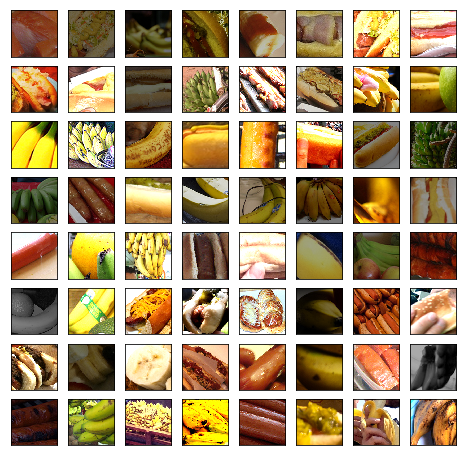

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_images(img_iter, nrows, ncols, figsize=None):
    if not figsize:
        figsize = (nrows, ncols)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(img_iter[j + i*ncols].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

train_images = gluon.data.vision.ImageFolderDataset(data_dir + '/hotdog/train', 
                    transform=lambda X, y: transform(X, y, train_augs))

test_images = gluon.data.vision.ImageFolderDataset(data_dir + '/hotdog/test',
                    transform=lambda X, y: transform(X, y, test_augs))

batch_size = 64
train_iter = gluon.data.DataLoader(train_images, batch_size=batch_size, shuffle=True)
test_iter = gluon.data.DataLoader(test_images, batch_size=batch_size, shuffle=False)

for data, _ in train_iter:
    print(data.shape)
    data = data.transpose((0,2,3,1))
    show_images(data, 8, 8)
    break

## 模型和训练

我们使用预训练的模型来训练我们的数据集

In [4]:
from mxnet.gluon.model_zoo import vision as models

pretrain_net = models.resnet18_v2(pretrained=True)

通常预训练好的模型由两块构成，一是features，二是output。后者主要包括最后一层全连接层，前者包含从输入开始的大部分层。这样的划分的一个主要目的是为了更方便做微调。我们先看下output的内容：

In [5]:
pretrain_net.features

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats

In [6]:
pretrain_net.output

Dense(512 -> 1000, linear)

In [7]:
pretrain_net.features[1].weight.data()[0][0]


[[-0.04693392  0.11487006 -0.13209556  0.16124195 -0.21484604  0.18044543
  -0.05956454]
 [-0.00242769 -0.03129578  0.01799692  0.15277492 -0.41541672  0.38176033
  -0.13370997]
 [ 0.10314132 -0.30472746  0.59482247 -0.52606624  0.0621427   0.25646785
  -0.12772678]
 [ 0.01783164 -0.21222414  0.58199424 -0.84664404  0.5702781  -0.20741715
   0.02784866]
 [ 0.01255781 -0.02931368  0.1608634  -0.3318552   0.31180814 -0.16463067
   0.05555796]
 [-0.0167121   0.03173966  0.00400858 -0.02572511 -0.02412852  0.08885808
  -0.04472235]
 [-0.05655501  0.08309566 -0.08147315  0.02597015 -0.03567177  0.0657132
  -0.03488606]]
<NDArray 7x7 @cpu(0)>

In [8]:
pretrain_net

ResNetV2(
  (features): HybridSequential(
    (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
    (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (3): Activation(relu)
    (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (5): HybridSequential(
      (0): BasicBlockV2(
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlockV2(
        (bn1): BatchNorm(axis=1, eps=1e

在微调里，我们一般新建一个网络，它的定义跟之前训练好的网络一样，除了最后的输出数等于当前数据的类别数。新网络的features被初始化前面训练好网络的权重，而output则是从头开始训练。

In [9]:
from mxnet import init

import utils
import mxnet as mx

ctx = mx.gpu()

finetune_net = models.resnet18_v2(classes=2)
finetune_net.features = pretrain_net.features
finetune_net.output.initialize(init=init.Xavier())

In [87]:
def train(net, ctx, batch_size=64, num_epochs=10, learning_rate=0.1, weight_decay=0.01):
    train_data = gluon.data.DataLoader(train_images, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_images, batch_size=batch_size, shuffle=False)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': weight_decay})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    utils.train(train_data, test_data, net, batch_size, num_epochs, trainer, loss, ctx)

In [11]:
train(finetune_net, batch_size=32, learning_rate=0.01, weight_decay=0.001, ctx=mx.gpu())

Start Training On: gpu(0)
Epoch 0, Moving Train Loss 0.24435, Train Loss 0.15110, Test Loss 0.19256, Train acc 0.93850, Test acc 0.92250, Time Consume 38.35600.
Epoch 1, Moving Train Loss 0.15008, Train Loss 0.08209, Test Loss 0.13883, Train acc 0.97200, Test acc 0.94375, Time Consume 32.64000.
Epoch 2, Moving Train Loss 0.13685, Train Loss 0.08196, Test Loss 0.14983, Train acc 0.97100, Test acc 0.94250, Time Consume 34.25300.
Epoch 3, Moving Train Loss 0.10083, Train Loss 0.05795, Test Loss 0.12518, Train acc 0.98150, Test acc 0.95000, Time Consume 32.03500.
Epoch 4, Moving Train Loss 0.06360, Train Loss 0.04415, Test Loss 0.14412, Train acc 0.98650, Test acc 0.94375, Time Consume 32.23200.
Epoch 5, Moving Train Loss 0.06134, Train Loss 0.03732, Test Loss 0.14201, Train acc 0.98700, Test acc 0.95125, Time Consume 32.78500.
Epoch 6, Moving Train Loss 0.05204, Train Loss 0.02227, Test Loss 0.14667, Train acc 0.99300, Test acc 0.94375, Time Consume 35.06500.
Epoch 7, Moving Train Loss 0.

In [12]:
scratch_net = models.resnet18_v2(classes=2)
scratch_net.initialize(init=mx.init.Xavier())
train(scratch_net, batch_size=32, learning_rate=0.01, weight_decay=0.001, ctx=mx.gpu())

Start Training On: gpu(0)
Epoch 0, Moving Train Loss 0.40248, Train Loss 0.42449, Test Loss 0.45735, Train acc 0.80750, Test acc 0.81000, Time Consume 34.83100.
Epoch 1, Moving Train Loss 0.40518, Train Loss 0.45187, Test Loss 0.40822, Train acc 0.79300, Test acc 0.80125, Time Consume 33.71600.
Epoch 2, Moving Train Loss 0.41458, Train Loss 0.45109, Test Loss 0.40318, Train acc 0.77900, Test acc 0.82750, Time Consume 34.17500.
Epoch 3, Moving Train Loss 0.34776, Train Loss 0.42098, Test Loss 0.41343, Train acc 0.82200, Test acc 0.82375, Time Consume 33.19000.
Epoch 4, Moving Train Loss 0.33874, Train Loss 0.39920, Test Loss 0.39023, Train acc 0.83750, Test acc 0.83375, Time Consume 32.54600.
Epoch 5, Moving Train Loss 0.35067, Train Loss 0.31208, Test Loss 0.32174, Train acc 0.87100, Test acc 0.87250, Time Consume 32.09300.
Epoch 6, Moving Train Loss 0.31593, Train Loss 0.30981, Test Loss 0.36092, Train acc 0.86650, Test acc 0.85375, Time Consume 31.74300.
Epoch 7, Moving Train Loss 0.

In [49]:
def classify_hotdog(net, fname):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    data, _ = transform(img, -1, test_augs)
    plt.imshow(data.transpose((1,2,0)).asnumpy())
    data = data.expand_dims(axis=0) # 将每一张图片扩展为4维向量
    output = net(data.as_in_context(ctx))
    output = nd.SoftmaxActivation(output)
    pred = int(nd.argmax(output, axis=1).asscalar())
    prob = output[0][pred].asscalar()
    label = train_images.synsets
    return 'prob=%f, %s' % (prob, label[pred])

'prob=0.863238, hotdog'

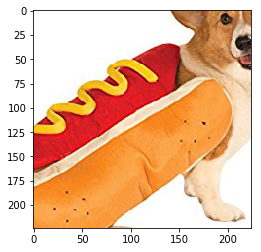

In [57]:
classify_hotdog(finetune_net, '../img/Chapter8-Computer-Vision/dog_hotdog.jpg')

'prob=0.999156, hotdog'

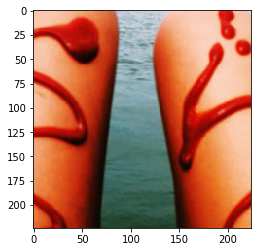

In [58]:
classify_hotdog(finetune_net, '../img/Chapter8-Computer-Vision/leg_hotdog.jpg')

'prob=0.999603, hotdog'

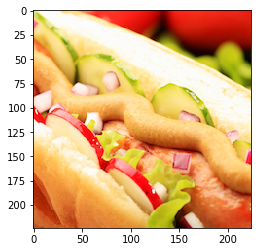

In [60]:
classify_hotdog(finetune_net, '../img/Chapter8-Computer-Vision/real_hotdog.jpg')

## 重用ImageNet预训练好的hotdog权重

In [89]:
weight = pretrain_net.output.weight
hotdog_w = nd.split(weight.data(), 1000, axis=0)[713] #(1000 list 1X512)
output_weight = nd.concat(hotdog_w, -hotdog_w, dim=0)
finetune_net.output.initialize(init=mx.init.Constant(output_weight))

d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter resnetv21_dense0_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter resnetv21_dense0_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


In [92]:
train(finetune_net, batch_size=32, num_epochs=20, learning_rate=0.01, weight_decay=0.001, ctx=mx.gpu())

Start Training On: gpu(0)
Epoch 0, Moving Train Loss 0.05451, Train Loss 0.02490, Test Loss 0.13446, Train acc 0.99200, Test acc 0.95000, Time Consume 32.52200.
Epoch 1, Moving Train Loss 0.04413, Train Loss 0.02029, Test Loss 0.12927, Train acc 0.99550, Test acc 0.95375, Time Consume 32.18400.
Epoch 2, Moving Train Loss 0.04040, Train Loss 0.01598, Test Loss 0.12018, Train acc 0.99550, Test acc 0.96000, Time Consume 31.86700.
Epoch 3, Moving Train Loss 0.02487, Train Loss 0.01146, Test Loss 0.12093, Train acc 0.99800, Test acc 0.96000, Time Consume 31.81100.
Epoch 4, Moving Train Loss 0.02687, Train Loss 0.01261, Test Loss 0.12438, Train acc 0.99750, Test acc 0.95750, Time Consume 31.81800.
Epoch 5, Moving Train Loss 0.02380, Train Loss 0.01247, Test Loss 0.12968, Train acc 0.99750, Test acc 0.95250, Time Consume 31.85600.
Epoch 6, Moving Train Loss 0.03208, Train Loss 0.00753, Test Loss 0.12638, Train acc 0.99900, Test acc 0.95875, Time Consume 31.83400.
Epoch 7, Moving Train Loss 0.

## 使用He提出的Xaiver参数初始化方法

In [93]:
w = nd.random.normal(0, np.sqrt(2/512), shape=(1,512))
output_weight = nd.concat(hotdog_w, w, dim=0)
finetune_net.output.initialize(mx.init.Constant(output_weight))

d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter resnetv21_dense0_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
d:\liang-jupyter\liang-jupyter\lib\site-packages\mxnet\gluon\parameter.py:320: UserWarning: Parameter resnetv21_dense0_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)


In [94]:
train(finetune_net, batch_size=32, num_epochs=20, learning_rate=0.01, weight_decay=0.001, ctx=mx.gpu())

Start Training On: gpu(0)
Epoch 0, Moving Train Loss 0.01634, Train Loss 0.00606, Test Loss 0.13119, Train acc 0.99800, Test acc 0.95500, Time Consume 33.71600.
Epoch 1, Moving Train Loss 0.01638, Train Loss 0.00317, Test Loss 0.12915, Train acc 0.99900, Test acc 0.95750, Time Consume 32.49300.
Epoch 2, Moving Train Loss 0.01847, Train Loss 0.00429, Test Loss 0.14292, Train acc 0.99950, Test acc 0.95500, Time Consume 31.94400.
Epoch 3, Moving Train Loss 0.01164, Train Loss 0.00451, Test Loss 0.12542, Train acc 0.99950, Test acc 0.95875, Time Consume 31.85000.
Epoch 4, Moving Train Loss 0.01401, Train Loss 0.00410, Test Loss 0.13521, Train acc 0.99850, Test acc 0.95500, Time Consume 32.12700.
Epoch 5, Moving Train Loss 0.00864, Train Loss 0.00355, Test Loss 0.11891, Train acc 0.99950, Test acc 0.96125, Time Consume 33.69500.
Epoch 6, Moving Train Loss 0.01605, Train Loss 0.00293, Test Loss 0.11767, Train acc 0.99950, Test acc 0.96125, Time Consume 31.80000.
Epoch 7, Moving Train Loss 0.

'prob=0.761580, hotdog'

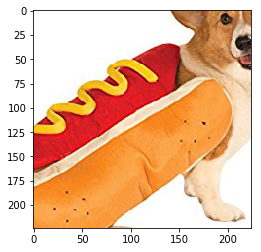

In [95]:
classify_hotdog(finetune_net, '../img/Chapter8-Computer-Vision/dog_hotdog.jpg')

我们可以看到，虽然判断依旧错误，但是prob已经降低了很多。下面我们将继续fine_tune我们的模型，争取更好的效果。